In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.mixture import GaussianMixture

In [5]:
df = pd.read_csv("../Data/Clean/all_data_SQL_Export.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country_ID              2398 non-null   int64  
 1   Country_Name            2398 non-null   object 
 2   Region                  2398 non-null   object 
 3   Year                    2398 non-null   int64  
 4   Happiness_Score         2398 non-null   float64
 5   Log_GDP_PEr_Capita      2398 non-null   float64
 6   Social_Support          2398 non-null   float64
 7   Life_Expectancy         2398 non-null   float64
 8   Freedom                 2398 non-null   float64
 9   Generosity              2398 non-null   float64
 10  Corruption              2398 non-null   float64
 11  %_Engaged               263 non-null    float64
 12  Average_hours_per_week  512 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 243.7+ KB


In [17]:
df.rename(columns={ 
    "Log_GDP_PEr_Capita": "Log_GDP_Per_Capita",
    "Happiness_Score": "Happiness",
    "%_Engaged": "Job_Engagement",
    "Average_hours_per_week": "Work_hours_per_week"
}, inplace=True)

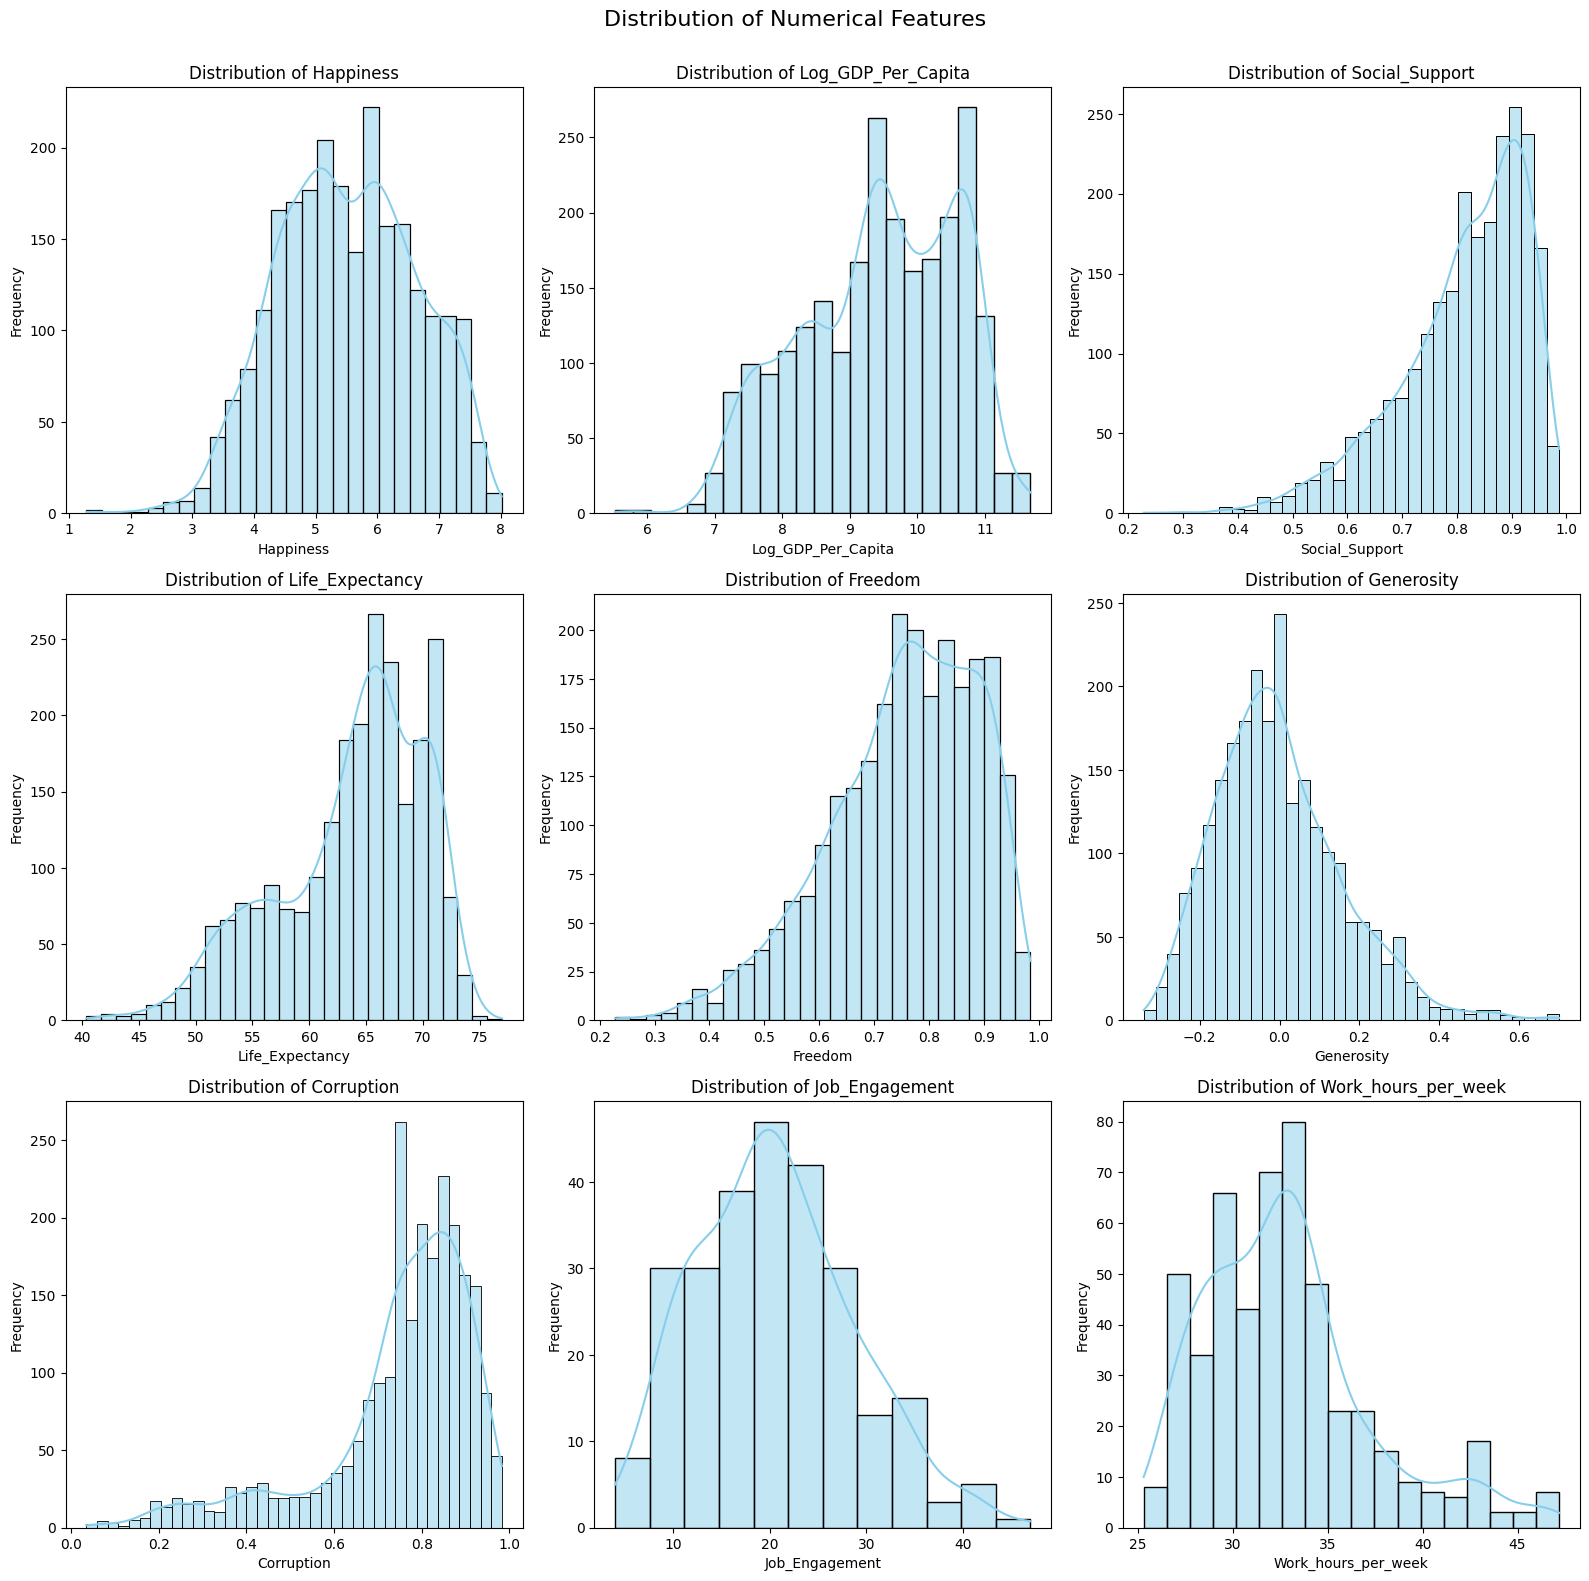

In [19]:
# Define numeric columns
numerical_columns = df.select_dtypes(include=['float64']).columns

# Distribution graphs for each numeric column
plt.figure(figsize=(16, 20))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i)
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.suptitle("Distribution of Numerical Features", y=1.02, fontsize=16)
plt.show()

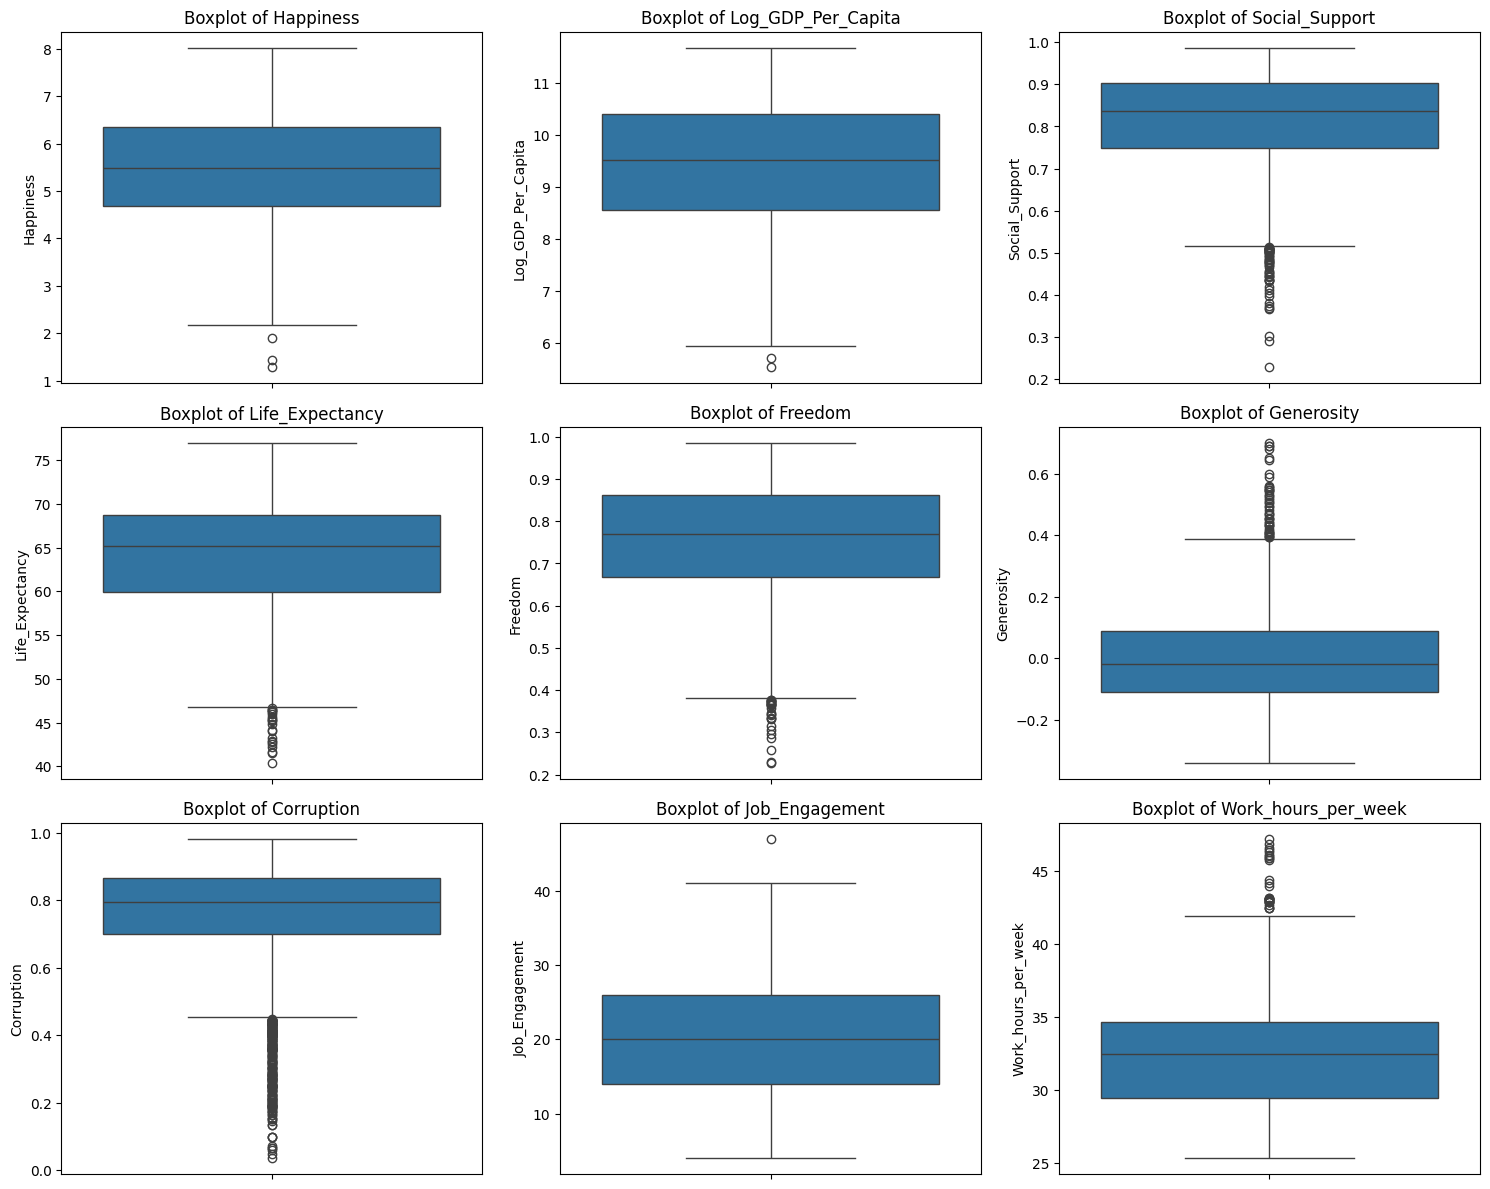

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    if col in df.columns:
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

*Analysis:*

**Happiness Score**
- Fairly normal distribution, with most values concentrated in the mid to high range.
- Mean: **5.52**, Standard Deviation: **1.12**
- Scores range from 1.28 (low happiness) to high 7s.
- The distribution seems roughly normal, but there are some low-score outliers like Afghanistan, likely due to the war and political situation.

**Log GDP Per Capita**
- Mean: **9.43**, with a wide standard deviation of **1.13.**
- Right-skewed distribution, indicating that most countries have lower GDP per capita, with fewer having very high GDP per capita.
- Venezuela is a major outlier with very low GDP, possibly due to economic crises.

**Social Support**
- Mean: **0.81**, with a fairly high lower bound (0.22).
- **No extreme outliers**, indicating that most countries have reasonable social support.

**Life Expectancy**
- Mean: **63.7 years**, but ranges from 40.4 to nearly 80.
- Normally distributed, with most values falling within a predictable range.
- There are likely outliers on the lower end, possibly due to developing countries with lower healthcare access.

**Freedom**
- Mean: **0.75**, but with some low-end outliers.
- The distribution is right skewed, possibly indicating that a subset of countries have significantly lower freedom scores.
- The minimum is **0.23**, suggesting some countries have much lower freedom scores.

**Generosity**
- Mean: **-0.001**, indicating some negative generosity values.
- A broad spread, with some outliers.

**Corruption**
- Mean: **0.75**, indicating that most countries report corruption.
-  Right skewed, most values seem to be concentrated in a certain range, suggesting that low corruption values are uncommon.
- The minimum is **0.035**, suggesting some countries have very low corruption.

**Job Engagement**
- Mean: **20.56%**, with a minimum of 4% engagement.
- Only included for 2023 and 2024

**Work Hours Per Week**
- Mean: **32.8 hours**
- Some outliers exist, as seen in the boxplot.
- Only included for OECD countries

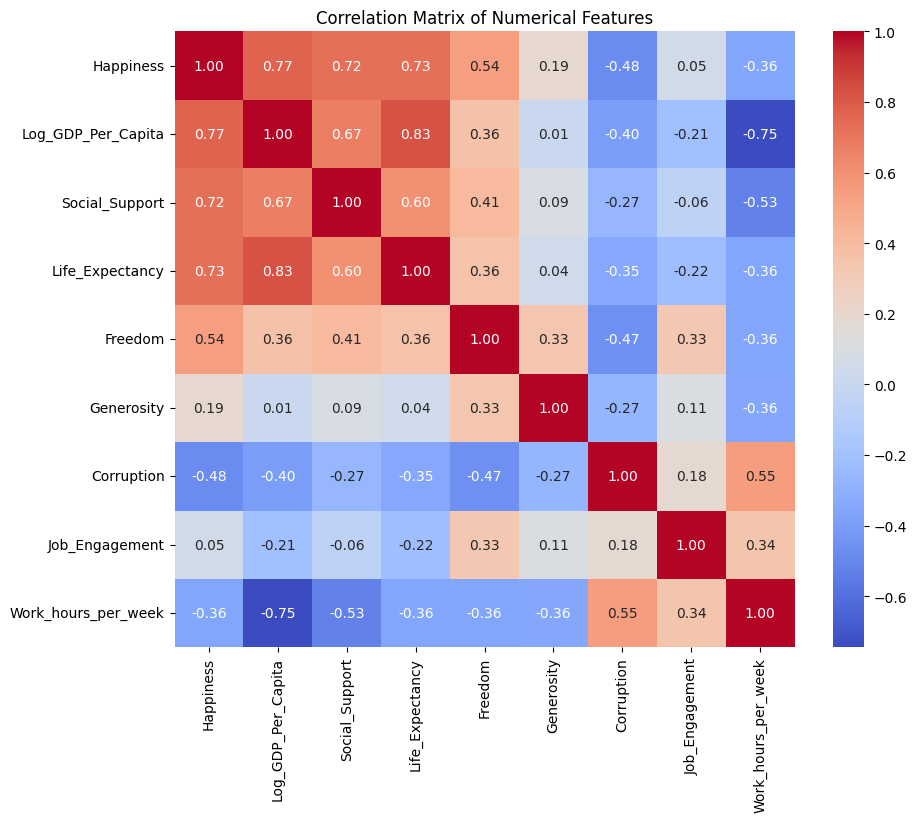

In [21]:

# Correlation Matrix Calculation
correlation_matrix = df[numerical_columns].corr()

# Correlation Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

*Analysis:*

**Strong Happiness Correlations**
- **Log GDP Per Capita (~0.77):** Wealthier countries tend to report higher happiness.
- **Life Expectancy (~0.73)**: Healthier countries are generally happier.
- **Social Support (~0.72):** Countries with strong support networks are generally happier.

**Moderate to Weak Happiness Correlations:**
- **Freedom (-0.54):** Freedom is related to higher happiness, but only moderately.
- **Corruption & Happiness (-0.48):** Higher corruption is associated with lower happiness, but not strongly.
- **Work Hours (-0.36):** Higher average weekly work hours is somewhat related to lower happiness, but not strong.

**Other Strong Correlations**
- **Life Expectancy & Social Support (~0.70):** Countries with better social support systems tend to have higher life expectancy.
- **Work Hours & GDP Per Capita (-0.75)** Countries with higher working hours tend to have less wealth
- **Work Hours & Corruptions (-0.55)** Countries with higher work hours tend to have more corruption

*Other notes*
- **Generosity** has a weak relationship with most factors, except for freedom.
- **Job Engagement** has weak relationships with most factors, also except for freedom



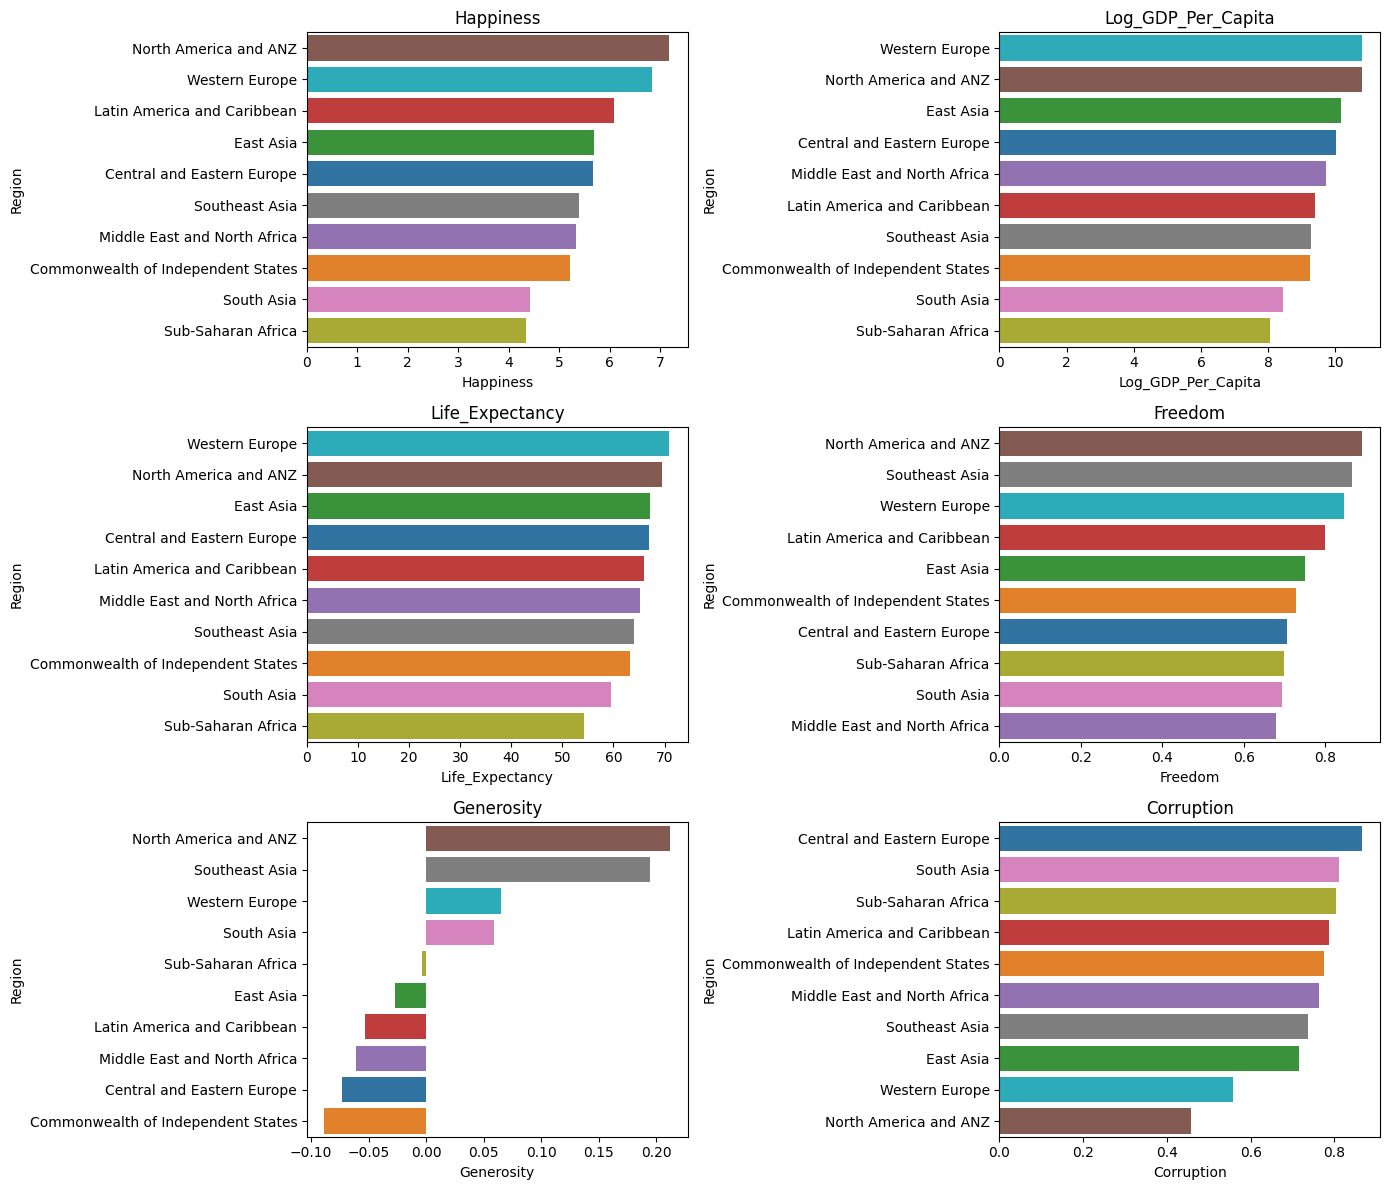

,Region,Happiness,Log_GDP_Per_Capita,Social_Support,Life_Expectancy,Freedom,Generosity,Corruption,Job_Engagement,Work_hours_per_week
0,Central and Eastern Europe,5.676824,10.017207,0.863877,66.904143,0.705222,-0.073495,0.865508,20.352941,32.912110
1,Commonwealth of Independent States,5.223251,9.237556,0.821168,63.298876,0.728082,-0.088685,0.774347,25.214286,NaN
2,East Asia,5.701639,10.162983,0.852792,67.242463,0.749046,-0.026832,0.715554,16.272727,35.630714
3,Latin America and Caribbean,6.084287,9.401166,0.857332,65.885157,0.799848,-0.053041,0.786518,27.194444,41.838000
4,Middle East and North Africa,5.336418,9.728751,0.786863,65.280627,0.679740,-0.060679,0.762948,15.757576,35.494615
5,North America and ANZ,7.186923,10.778403,0.931814,69.451697,0.889328,0.212261,0.457094,24.000000,33.290714
6,South Asia,4.417110,8.433449,0.641789,59.493992,0.693910,0.059236,0.810469,22.166667,NaN
7,Southeast Asia,5.391181,9.265039,0.806095,64.014854,0.864149,0.194784,0.736360,22.588235,NaN
8,Sub-Saharan Africa,4.352487,8.037858,0.708365,54.135090,0.698363,-0.003817,0.804498,21.810345,NaN
9,Western Europe,6.849199,10.785080,0.916213,70.940925,0.844706,0.065277,0.557553,14.425000,29.926176


In [62]:
# Regional Analysis
region_summary = df.groupby("Region")[numerical_columns].mean().reset_index()

# fixed color palette for regions
unique_regions = region_summary["Region"].unique()
region_colors = dict(zip(unique_regions, sns.color_palette("tab10", len(unique_regions))))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

#Dropping Work Hours & Job Engagement because data was incomplete
metrics = ["Happiness", "Log_GDP_Per_Capita", "Life_Expectancy", "Freedom", "Generosity", "Corruption"]

for i, metric in enumerate(metrics):
    sorted_data = region_summary.sort_values(by=metric, ascending=False)

    colors = [region_colors[region] for region in sorted_data["Region"]]

    sns.barplot(
        y=sorted_data["Region"],
        x=sorted_data[metric],
        ax=axes[i],
        palette=colors 
    )
    axes[i].set_title(f"{metric}")

plt.tight_layout()
plt.show()
region_summary


*Analysis*

**Happiness Score:**
- **North America + Australia and New Zealand** have the highest average happiness score.
- **Sub Saharan Africa** has the lowest happiness score among the regions analyzed.

**Log GDP Per Capita:**
- **Western Europe** has the highest GDP per capita (10.78), followed closely by North America and ANZ (10.78).
- **Sub Saharan Africa** has the lowest GDP per capita.

**Life Expectancy:**
- **Western Europe** has the highest average life expectancy (70.9)
- **Sub Saharan Africa** has much lower life expectancy compared to other regions (~54)

**Freedom:**
-**North America + Australia and New Zealand** has the highest freedom scores.
- **Middle East & North Africa** has the lowest freedom scores.

**Generosity:**
- Generosity scores are negative across most regions *except* North America, ANZ, Southeast Asia, Western Europe, South Asia
- **Commonwealth of Independent states** (former soviet republics) have the lowest generosity scores.

**Corruption**
- **Central & Eastern Europe** has the highest corruption levels.
- **North America and ANZ** show the lowest corruption levels among the regions analyzed.

,Region,Happiness,Log_GDP_Per_Capita,Social_Support,Life_Expectancy,Freedom,Generosity,Corruption,Job_Engagement,Work_hours_per_week
0,Central and Eastern Europe,5.676824,10.017207,0.863877,66.904143,0.705222,-0.073495,0.865508,20.352941,32.912110
1,Commonwealth of Independent States,5.223251,9.237556,0.821168,63.298876,0.728082,-0.088685,0.774347,25.214286,NaN
2,East Asia,5.701639,10.162983,0.852792,67.242463,0.749046,-0.026832,0.715554,16.272727,35.630714
3,Latin America and Caribbean,6.084287,9.401166,0.857332,65.885157,0.799848,-0.053041,0.786518,27.194444,41.838000
4,Middle East and North Africa,5.336418,9.728751,0.786863,65.280627,0.679740,-0.060679,0.762948,15.757576,35.494615
5,North America and ANZ,7.186923,10.778403,0.931814,69.451697,0.889328,0.212261,0.457094,24.000000,33.290714
6,South Asia,4.417110,8.433449,0.641789,59.493992,0.693910,0.059236,0.810469,22.166667,NaN
7,Southeast Asia,5.391181,9.265039,0.806095,64.014854,0.864149,0.194784,0.736360,22.588235,NaN
8,Sub-Saharan Africa,4.352487,8.037858,0.708365,54.135090,0.698363,-0.003817,0.804498,21.810345,NaN
9,Western Europe,6.849199,10.785080,0.916213,70.940925,0.844706,0.065277,0.557553,14.425000,29.926176


In [84]:
# Creating a ranking table for each country in each category for every year

# Define the key metrics to rank
ranking_metrics = ["Happiness", "Log_GDP_Per_Capita", "Life_Expectancy", "Freedom", "Corruption", "Social_Support"]

# Compute ranks for each metric within each year
ranked_df = df.copy()
for metric in ranking_metrics:
    ranked_df[f"{metric}_Rank"] = ranked_df.groupby("Year")[metric].rank(ascending=False, method="min")

# Select relevant columns for the ranking table
ranked_df = ranked_df[["Country_Name", "Year"] + [f"{metric}_Rank" for metric in ranking_metrics]]

# Display the ranked data table
display(ranked_df)

,Country_Name,Year,Happiness_Rank,Log_GDP_Per_Capita_Rank,Life_Expectancy_Rank,Freedom_Rank,Corruption_Rank,Social_Support_Rank
0,Czechia,2018,15.0,29.0,34.0,71.0,35.0,17.0
1,Czechia,2021,13.0,28.0,34.0,24.0,25.0,6.0
2,Czechia,2020,16.0,28.0,33.0,24.0,17.0,3.0
3,Czechia,2023,18.0,28.0,38.0,19.0,39.0,14.0
4,Czechia,2024,18.0,32.0,39.0,22.0,35.0,10.0
...,...,...,...,...,...,...,...,...
2393,Greece,2016,78.0,41.0,22.0,132.0,19.0,86.0
2394,Greece,2017,85.0,43.0,22.0,138.0,20.0,102.0
2395,Greece,2012,76.0,37.0,18.0,129.0,2.0,75.0
2396,Greece,2014,94.0,38.0,19.0,133.0,8.0,64.0


In [88]:
# Calculating year-over-year rank changes for each country
rank_change_df = ranked_df.copy()

# Compute year-over-year differences in rank for each metric
for metric in ranking_metrics:
    rank_change_df[f"{metric}_Rank_Change"] = rank_change_df.groupby("Country_Name")[f"{metric}_Rank"].diff()

# Melt the data to structure it for identifying the biggest movers
rank_movers = rank_change_df.melt(
    id_vars=["Country_Name", "Year"], 
    value_vars=[f"{metric}_Rank_Change" for metric in ranking_metrics],
    var_name="Metric",
    value_name="Rank_Change"
).dropna()

# Identify the biggest year-over-year rank changes (absolute values)
biggest_rank_movers = rank_movers.sort_values(by="Rank_Change", key=abs, ascending=False).head(20)

display(biggest_rank_movers)


,Country_Name,Year,Metric,Rank_Change
11862,Germany,2022,Corruption_Rank_Change,119.0
11704,Sweden,2018,Corruption_Rank_Change,117.0
11703,Sweden,2005,Corruption_Rank_Change,-114.0
9578,Greece,2019,Freedom_Rank_Change,111.0
11353,Gambia,2017,Corruption_Rank_Change,107.0
11721,Netherlands,2018,Corruption_Rank_Change,105.0
7380,Hungary,2014,Freedom_Rank_Change,105.0
8498,Pakistan,2005,Freedom_Rank_Change,-104.0
11524,Tanzania,2019,Corruption_Rank_Change,102.0
13294,Pakistan,2005,Social_Support_Rank_Change,-102.0


In [90]:
# Recalculate year-over-year rank changes excluding Corruption and Freedom
filtered_rank_change_df = ranked_df.copy()

# Define the metrics to keep
filtered_metrics = ["Happiness", "Log_GDP_Per_Capita", "Life_Expectancy", "Social_Support"]

# Compute year-over-year differences in rank for selected metrics
for metric in filtered_metrics:
    filtered_rank_change_df[f"{metric}_Rank_Change"] = filtered_rank_change_df.groupby("Country_Name")[f"{metric}_Rank"].diff()

# Melt the data to structure it for identifying the biggest movers
filtered_rank_movers = filtered_rank_change_df.melt(
    id_vars=["Country_Name", "Year"], 
    value_vars=[f"{metric}_Rank_Change" for metric in filtered_metrics],
    var_name="Metric",
    value_name="Rank_Change"
).dropna()

# Identify the biggest year-over-year rank changes (absolute values)
filtered_biggest_rank_movers = filtered_rank_movers.sort_values(by="Rank_Change", key=abs, ascending=False).head(20)

# Display the biggest movers in ranking (excluding Corruption and Freedom)
display(filtered_biggest_rank_movers)


,Country_Name,Year,Metric,Rank_Change
8498,Pakistan,2005,Social_Support_Rank_Change,-102.0
5376,Hong Kong S.A.R. of China,2022,Life_Expectancy_Rank_Change,90.0
8264,Iran,2013,Social_Support_Rank_Change,89.0
5375,Hong Kong S.A.R. of China,2024,Life_Expectancy_Rank_Change,-86.0
8976,Kenya,2007,Social_Support_Rank_Change,-83.0
6100,Pakistan,2005,Life_Expectancy_Rank_Change,-80.0
1067,Turkiye,2021,Happiness_Rank_Change,79.0
8499,Pakistan,2009,Social_Support_Rank_Change,78.0
3702,Pakistan,2005,Log_GDP_Per_Capita_Rank_Change,-78.0
3789,Singapore,2008,Log_GDP_Per_Capita_Rank_Change,-77.0


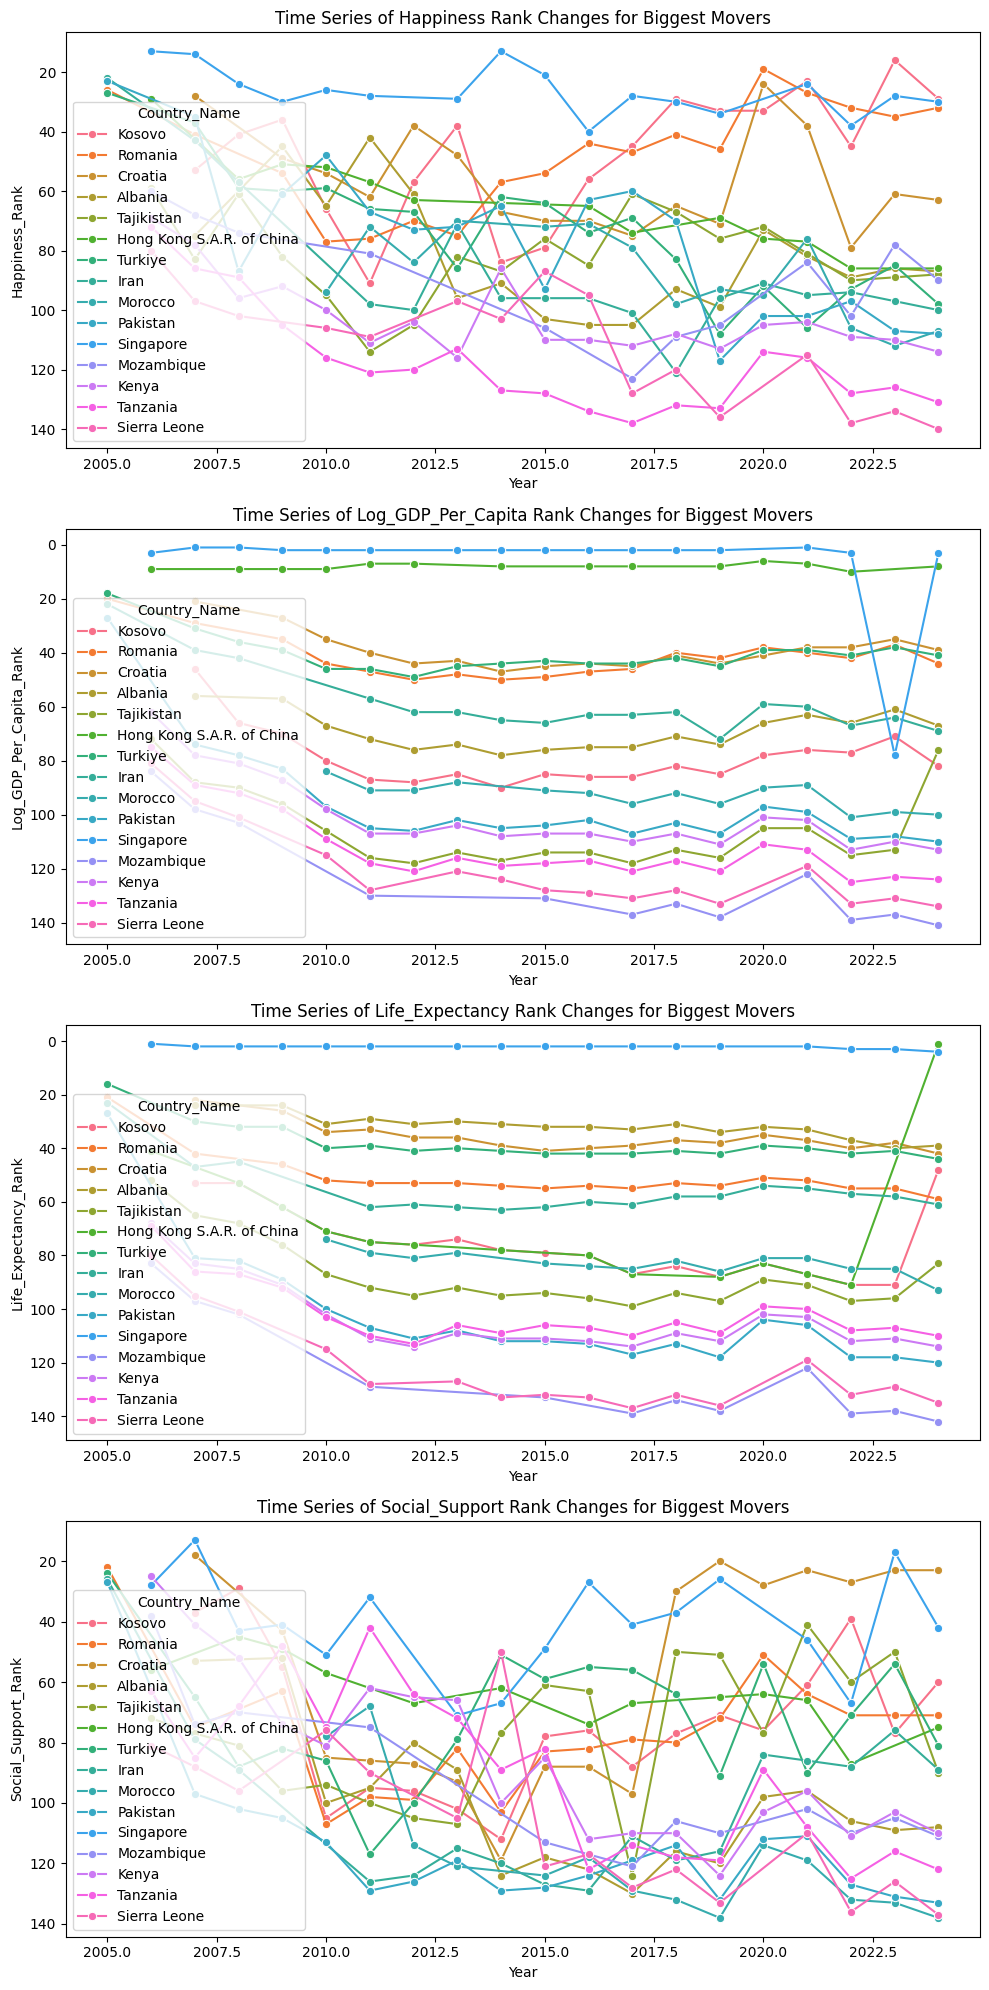

In [100]:
# Filter the dataset to include only the biggest movers identified earlier
top_moving_countries = filtered_biggest_rank_movers["Country_Name"].unique()
filtered_time_series = filtered_rank_change_df[filtered_rank_change_df["Country_Name"].isin(top_moving_countries)]

# Create a time series plot for each metric showing rank changes over time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
axes = axes.flatten()

# Plot trends for each selected metric
for i, metric in enumerate(filtered_metrics):
    sns.lineplot(
        data=filtered_time_series, 
        x="Year", 
        y=f"{metric}_Rank", 
        hue="Country_Name", 
        marker="o", 
        ax=axes[i]
    )
    axes[i].set_title(f"Time Series of {metric} Rank Changes for Biggest Movers")
    axes[i].invert_yaxis()  # Lower ranks (better positions) should be at the top

plt.tight_layout()
plt.show()
